In [31]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision import transforms
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

device = 'cuda'

# Machine Learning Lifecycle

## 1. Exploración y preprocesamiento de los datos.

### a y b. Carga dataset Fashion-MNIST e Implementa el preprocesamiento

In [2]:
transofrmador = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transofrmador,)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transofrmador,)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

Contamos con 10 posibles prendas

In [3]:
clases = {
    0: 'Camiseta/Top',
    1: 'Pantalón',
    2: 'Suéter',
    3: 'Vestido',
    4: 'Abrigo',
    5: 'Sandalia',
    6: 'Camisa',
    7: 'Zapato',
    8: 'Bolsa',
    9: 'Bota'
}

#### Visualización de imagenes

Las imagenes ya se encuentran preparadas para cualquier modelo, ya se encuentra en una escala de grises, con el fondo negro claramente diferenciado, por el momento no es necesario aplicar un preprocesamiento como alguna transformación geométrica, reducción de ruido o transformación de color

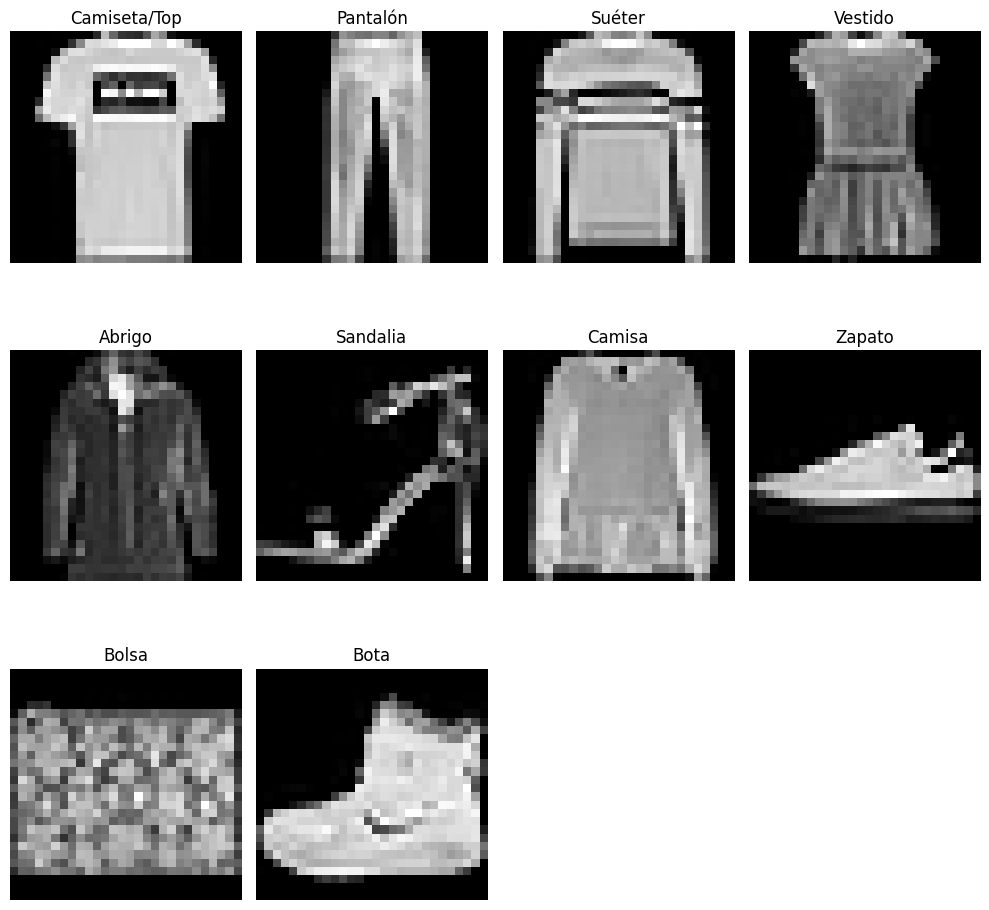

In [4]:
plt.figure(figsize=(10, 10))
for i in range(10):

    index = next(index for index, label in enumerate(train_data.targets) if label == i)

    imagen, label = train_data[index]

    plt.subplot(3, 4, i + 1)  # Ajusta según el número de clases
    plt.imshow(imagen.squeeze(), cmap='gray')
    plt.title(clases[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2. Selección del modelo y entrenamiento.

### Utilidades

In [8]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10, device='cuda'):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    model_parameters = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        model_parameters.append(model.state_dict())

    epochs = range(1, len(train_losses) + 1)

    return train_losses, val_losses, train_accs, val_accs, model_parameters

def graficar(
    train_losses,
    val_losses,
    train_accs,
    val_accs,
    label_1,
    label_2,
    label_3,
    label_4,
  ):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label=label_1, markersize=5)
    plt.plot(epochs, val_losses, 'ro--', label=label_2, markersize=5)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label=label_3, markersize=5)
    plt.plot(epochs, val_accs, 'ro--', label=label_4, markersize=5)
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Modelo con 2 capas lineares de 600 neuronas y función de activación ReLu

Epoch [1/20], Train Loss: 0.8871, Train Acc: 0.7341, Val Loss: 0.4711, Val Acc: 0.8251
Epoch [2/20], Train Loss: 0.4473, Train Acc: 0.8325, Val Loss: 0.4210, Val Acc: 0.8415
Epoch [3/20], Train Loss: 0.3887, Train Acc: 0.8560, Val Loss: 0.4628, Val Acc: 0.8277
Epoch [4/20], Train Loss: 0.3717, Train Acc: 0.8615, Val Loss: 0.3697, Val Acc: 0.8648
Epoch [5/20], Train Loss: 0.3358, Train Acc: 0.8762, Val Loss: 0.3668, Val Acc: 0.8678
Epoch [6/20], Train Loss: 0.3173, Train Acc: 0.8811, Val Loss: 0.3952, Val Acc: 0.8571
Epoch [7/20], Train Loss: 0.3002, Train Acc: 0.8875, Val Loss: 0.3575, Val Acc: 0.8710
Epoch [8/20], Train Loss: 0.2879, Train Acc: 0.8901, Val Loss: 0.3306, Val Acc: 0.8802
Epoch [9/20], Train Loss: 0.2695, Train Acc: 0.8973, Val Loss: 0.3621, Val Acc: 0.8686
Epoch [10/20], Train Loss: 0.2603, Train Acc: 0.9016, Val Loss: 0.3137, Val Acc: 0.8890
Epoch [11/20], Train Loss: 0.2546, Train Acc: 0.9034, Val Loss: 0.3487, Val Acc: 0.8738
Epoch [12/20], Train Loss: 0.2336, Train 

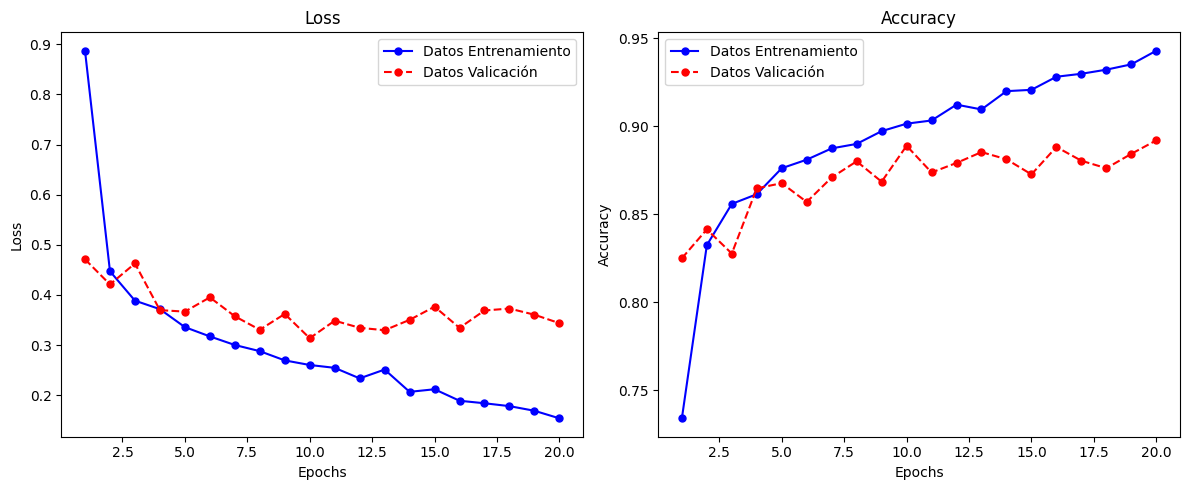

In [9]:
class NNFashionMnist(nn.Module):

    def __init__(self):

        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 600),
            nn.ReLU(),
            nn.Linear(600, 600),
            nn.ReLU(),
            nn.Linear(600, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NNFashionMnist().to(device)

lr = 0.001
epochs = 10
funcion_de_perdida = nn.CrossEntropyLoss()

optimizador = torch.optim.RMSprop(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, model_parameters = train_model(
    model,
    train_loader,
    val_loader,
    optimizador,
    funcion_de_perdida,
    epochs=20,
)

graficar(
    train_losses,
    val_losses,
    train_accs,
    val_accs,
    'Datos Entrenamiento',
    'Datos Valicación',
    'Datos Entrenamiento',
    'Datos Valicación',
)

### Modelo con 2 capas lineares de 600 neuronas y función de activación ReLu y función de perdida con regularización L2

Epoch [1/30], Train Loss: 0.6170, Train Acc: 0.7779, Val Loss: 0.4710, Val Acc: 0.8275
Epoch [2/30], Train Loss: 0.4087, Train Acc: 0.8512, Val Loss: 0.4271, Val Acc: 0.8488
Epoch [3/30], Train Loss: 0.3691, Train Acc: 0.8662, Val Loss: 0.3733, Val Acc: 0.8647
Epoch [4/30], Train Loss: 0.3450, Train Acc: 0.8740, Val Loss: 0.3627, Val Acc: 0.8662
Epoch [5/30], Train Loss: 0.3296, Train Acc: 0.8785, Val Loss: 0.3579, Val Acc: 0.8710
Epoch [6/30], Train Loss: 0.3144, Train Acc: 0.8839, Val Loss: 0.3314, Val Acc: 0.8804
Epoch [7/30], Train Loss: 0.2993, Train Acc: 0.8900, Val Loss: 0.3376, Val Acc: 0.8802
Epoch [8/30], Train Loss: 0.2909, Train Acc: 0.8929, Val Loss: 0.3444, Val Acc: 0.8760
Epoch [9/30], Train Loss: 0.2824, Train Acc: 0.8958, Val Loss: 0.3528, Val Acc: 0.8717
Epoch [10/30], Train Loss: 0.2873, Train Acc: 0.8952, Val Loss: 0.3496, Val Acc: 0.8718
Epoch [11/30], Train Loss: 0.2760, Train Acc: 0.8988, Val Loss: 0.3205, Val Acc: 0.8872
Epoch [12/30], Train Loss: 0.2619, Train 

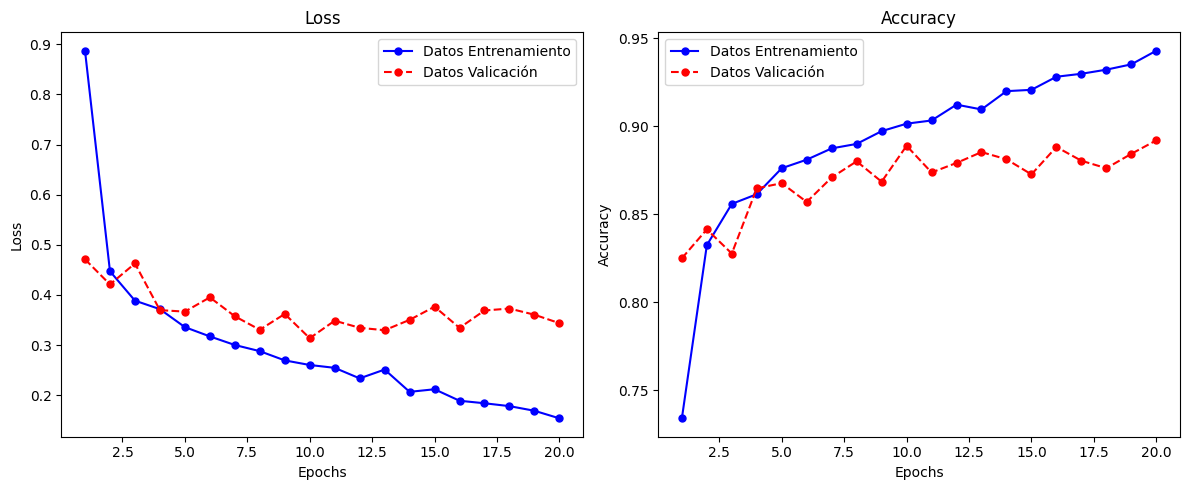

In [10]:
lr = 0.001
funcion_de_perdida = nn.CrossEntropyLoss()

model_2 = NNFashionMnist().to(device)
optimizador_l2 = torch.optim.Adam(model_2.parameters(), lr=0.001, weight_decay=0.001)

train_losses_2, val_losses_2, train_accs_2, val_accs_2, model_parameters_2 = train_model(
    model_2,
    train_loader,
    val_loader,
    optimizador_l2,
    funcion_de_perdida,
    epochs=30,
)

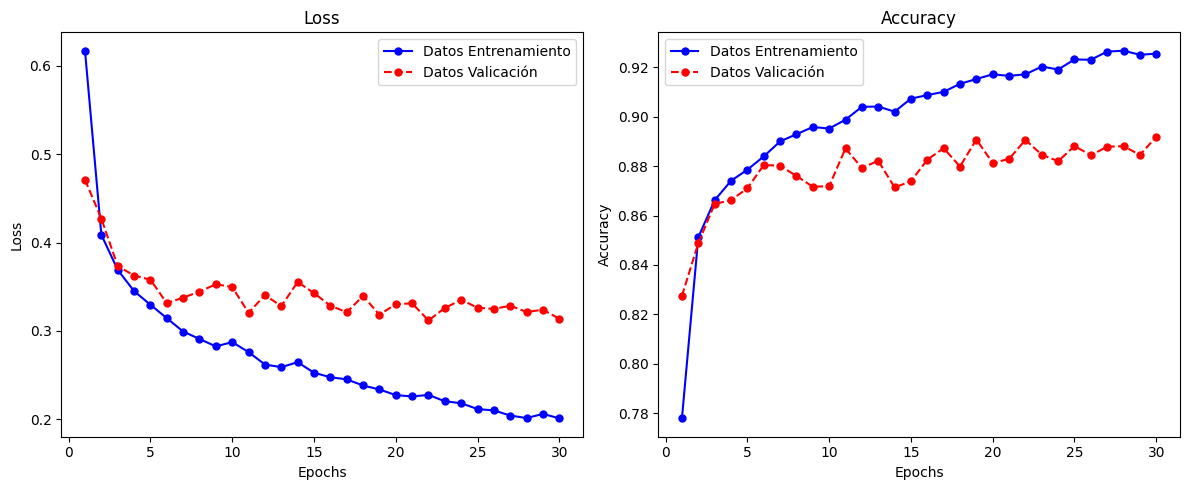

In [12]:
graficar(
    train_losses_2,
    val_losses_2,
    train_accs_2,
    val_accs_2,
    'Datos Entrenamiento',
    'Datos Valicación',
    'Datos Entrenamiento',
    'Datos Valicación',
)

Modelo con 2 capas lineares de 500 neuronas y función de activación ReLu, función de perdida con regularización L2 y dropout del 50% en la fase de optimización

Epoch [1/50], Train Loss: 0.7290, Train Acc: 0.7342, Val Loss: 0.4755, Val Acc: 0.8302
Epoch [2/50], Train Loss: 0.4851, Train Acc: 0.8224, Val Loss: 0.4130, Val Acc: 0.8525
Epoch [3/50], Train Loss: 0.4469, Train Acc: 0.8378, Val Loss: 0.3875, Val Acc: 0.8599
Epoch [4/50], Train Loss: 0.4191, Train Acc: 0.8468, Val Loss: 0.3822, Val Acc: 0.8629
Epoch [5/50], Train Loss: 0.4063, Train Acc: 0.8528, Val Loss: 0.3712, Val Acc: 0.8659
Epoch [6/50], Train Loss: 0.3951, Train Acc: 0.8555, Val Loss: 0.3717, Val Acc: 0.8643
Epoch [7/50], Train Loss: 0.3876, Train Acc: 0.8591, Val Loss: 0.3632, Val Acc: 0.8667
Epoch [8/50], Train Loss: 0.3835, Train Acc: 0.8606, Val Loss: 0.3626, Val Acc: 0.8693
Epoch [9/50], Train Loss: 0.3765, Train Acc: 0.8630, Val Loss: 0.3512, Val Acc: 0.8752
Epoch [10/50], Train Loss: 0.3750, Train Acc: 0.8634, Val Loss: 0.3589, Val Acc: 0.8710
Epoch [11/50], Train Loss: 0.3699, Train Acc: 0.8669, Val Loss: 0.3576, Val Acc: 0.8712
Epoch [12/50], Train Loss: 0.3653, Train 

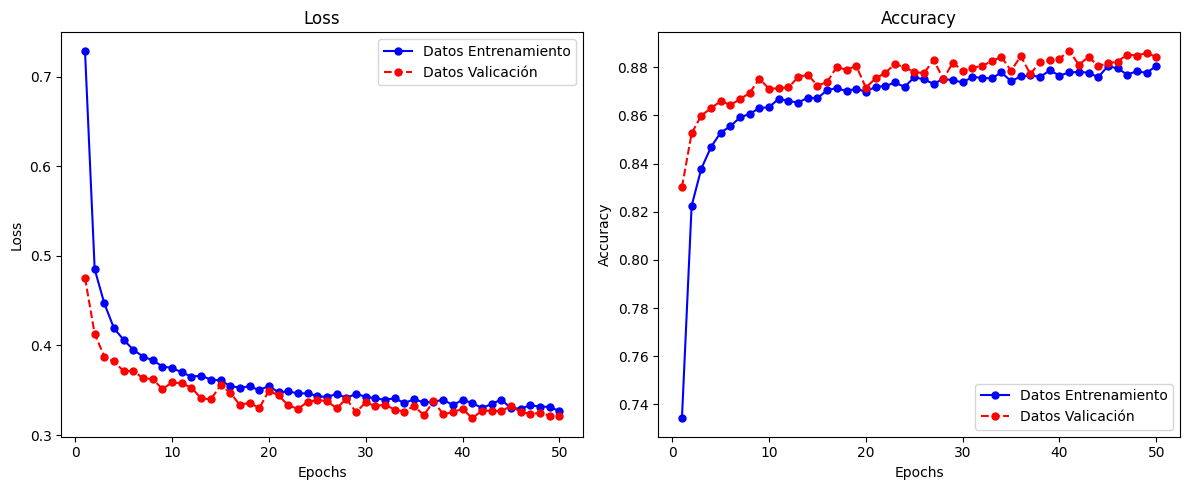

In [13]:
class NNFashionMnistDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)  # Dropout con probabilidad de apagado de 0.5
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 500),
            nn.ReLU(),
            self.dropout,  # Aplicar dropout después de la primera capa lineal
            nn.Linear(500, 500),
            nn.ReLU(),
            self.dropout,  # Aplicar dropout después de la segunda capa lineal
            nn.Linear(500, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

lr = 0.001
funcion_de_perdida = nn.CrossEntropyLoss()

model_3 = NNFashionMnistDropout().to(device)
optimizador_l2 = torch.optim.Adam(model_3.parameters(), lr=0.001, weight_decay=0.001)

train_losses_3, val_losses_3, train_accs_3, val_accs_3, model_parameters_3 = train_model(
    model_3,
    train_loader,
    val_loader,
    optimizador_l2,
    funcion_de_perdida,
    epochs=50,
)

graficar(
    train_losses_3,
    val_losses_3,
    train_accs_3,
    val_accs_3,
    'Datos Entrenamiento',
    'Datos Valicación',
    'Datos Entrenamiento',
    'Datos Valicación',
)

### Modelo con 2 capas lineares de 500 neuronas y función de activación ReLu, función de perdida con regularización L2 y dropout del 50% en la fase de optimización

Epoch [1/50], Train Loss: 0.6695, Train Acc: 0.7590, Val Loss: 0.4599, Val Acc: 0.8360
Epoch [2/50], Train Loss: 0.4412, Train Acc: 0.8389, Val Loss: 0.4002, Val Acc: 0.8552
Epoch [3/50], Train Loss: 0.4070, Train Acc: 0.8509, Val Loss: 0.3849, Val Acc: 0.8614
Epoch [4/50], Train Loss: 0.3737, Train Acc: 0.8631, Val Loss: 0.3590, Val Acc: 0.8722
Epoch [5/50], Train Loss: 0.3585, Train Acc: 0.8675, Val Loss: 0.3596, Val Acc: 0.8735
Epoch [6/50], Train Loss: 0.3555, Train Acc: 0.8689, Val Loss: 0.3551, Val Acc: 0.8708
Epoch [7/50], Train Loss: 0.3438, Train Acc: 0.8745, Val Loss: 0.3409, Val Acc: 0.8796
Epoch [8/50], Train Loss: 0.3353, Train Acc: 0.8777, Val Loss: 0.3390, Val Acc: 0.8788
Epoch [9/50], Train Loss: 0.3301, Train Acc: 0.8790, Val Loss: 0.3348, Val Acc: 0.8779
Epoch [10/50], Train Loss: 0.3278, Train Acc: 0.8797, Val Loss: 0.3410, Val Acc: 0.8760
Epoch [11/50], Train Loss: 0.3220, Train Acc: 0.8818, Val Loss: 0.3259, Val Acc: 0.8837
Epoch [12/50], Train Loss: 0.3179, Train 

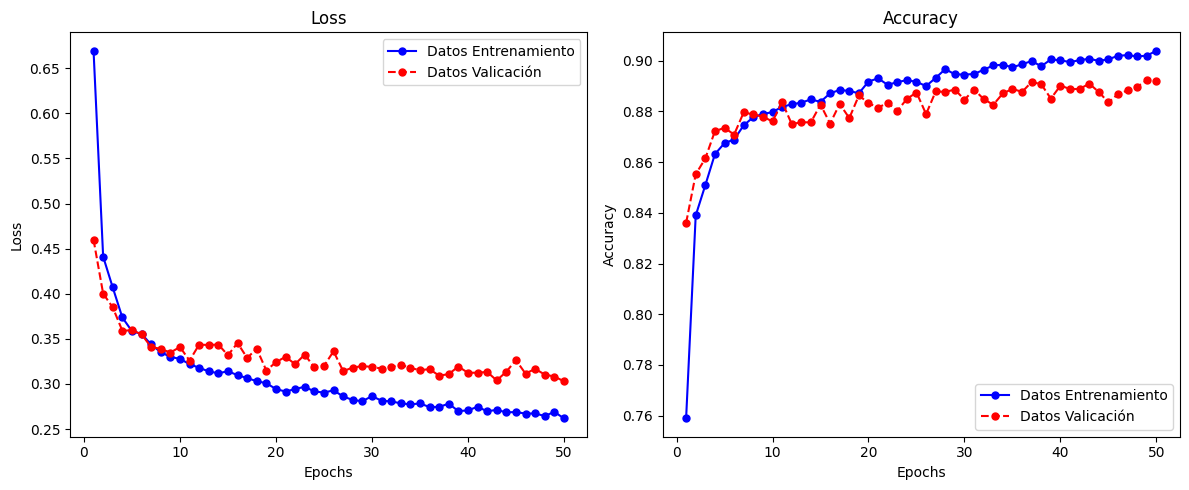

In [15]:
class NNFashionMnistDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.3)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 500),
            nn.ReLU(),
            self.dropout,
            nn.Linear(500, 500),
            nn.ReLU(),
            self.dropout,
            nn.Linear(500, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

lr = 0.001
funcion_de_perdida = nn.CrossEntropyLoss()

model_4 = NNFashionMnistDropout().to(device)
optimizador_l2 = torch.optim.Adam(model_4.parameters(), lr=0.001, weight_decay=0.001)

train_losses_4, val_losses_4, train_accs_4, val_accs_4, model_parameters_4 = train_model(
    model_4,
    train_loader,
    val_loader,
    optimizador_l2,
    funcion_de_perdida,
    epochs=50,
)

graficar(
    train_losses_4,
    val_losses_4,
    train_accs_4,
    val_accs_4,
    'Datos Entrenamiento',
    'Datos Valicación',
    'Datos Entrenamiento',
    'Datos Valicación',
)

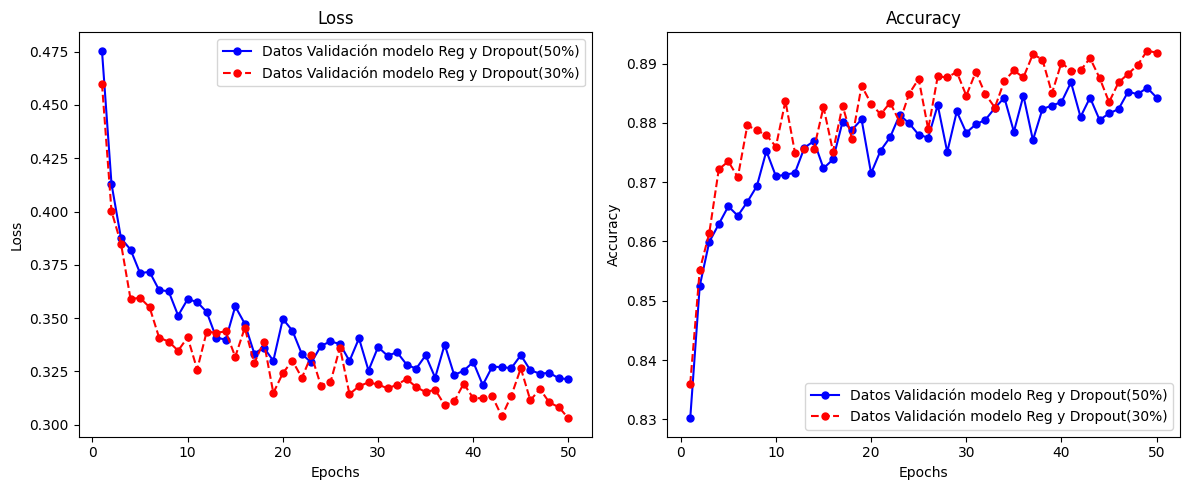

In [17]:
graficar(
    val_losses_3,
    val_losses_4,
    val_accs_3,
    val_accs_4,
    'Datos Validación modelo Reg y Dropout(50%)',
    'Datos Validación modelo Reg y Dropout(30%)',
    'Datos Validación modelo Reg y Dropout(50%)',
    'Datos Validación modelo Reg y Dropout(30%)',
    )

Epoch [1/50], Train Loss: 0.6530, Train Acc: 0.7662, Val Loss: 0.4485, Val Acc: 0.8375
Epoch [2/50], Train Loss: 0.4294, Train Acc: 0.8446, Val Loss: 0.4033, Val Acc: 0.8523
Epoch [3/50], Train Loss: 0.3866, Train Acc: 0.8594, Val Loss: 0.3910, Val Acc: 0.8599
Epoch [4/50], Train Loss: 0.3682, Train Acc: 0.8640, Val Loss: 0.3689, Val Acc: 0.8682
Epoch [5/50], Train Loss: 0.3494, Train Acc: 0.8707, Val Loss: 0.3651, Val Acc: 0.8662
Epoch [6/50], Train Loss: 0.3377, Train Acc: 0.8770, Val Loss: 0.3412, Val Acc: 0.8734
Epoch [7/50], Train Loss: 0.3282, Train Acc: 0.8795, Val Loss: 0.3624, Val Acc: 0.8695
Epoch [8/50], Train Loss: 0.3269, Train Acc: 0.8796, Val Loss: 0.3261, Val Acc: 0.8831
Epoch [9/50], Train Loss: 0.3125, Train Acc: 0.8840, Val Loss: 0.3310, Val Acc: 0.8804
Epoch [10/50], Train Loss: 0.3090, Train Acc: 0.8869, Val Loss: 0.3317, Val Acc: 0.8807
Epoch [11/50], Train Loss: 0.3074, Train Acc: 0.8880, Val Loss: 0.3336, Val Acc: 0.8787
Epoch [12/50], Train Loss: 0.2973, Train 

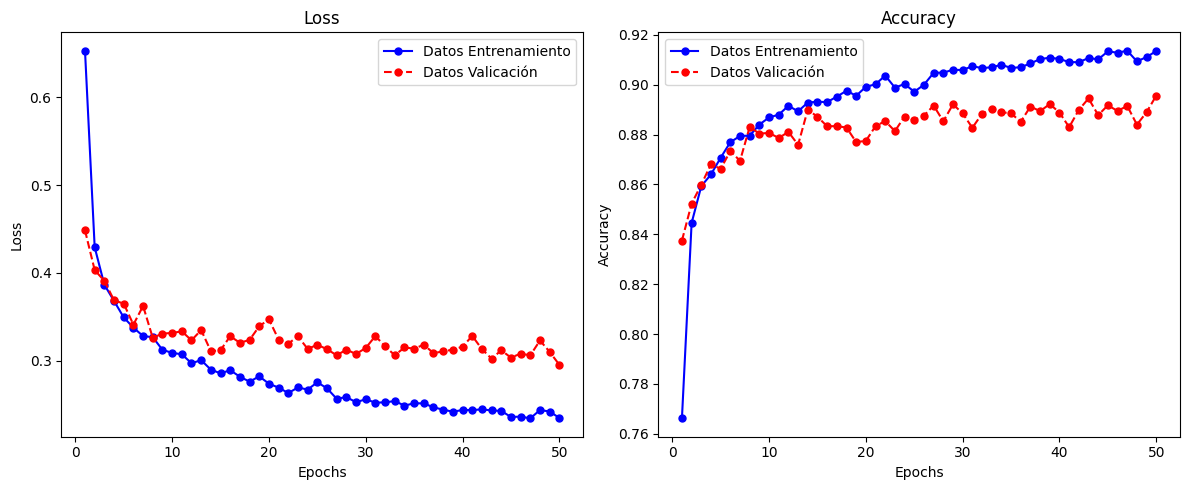

In [18]:
class NNFashionMnistDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.2)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 500),
            nn.ReLU(),
            self.dropout,
            nn.Linear(500, 500),
            nn.ReLU(),
            self.dropout,
            nn.Linear(500, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

lr = 0.001
funcion_de_perdida = nn.CrossEntropyLoss()

model_5 = NNFashionMnistDropout().to(device)
optimizador_l2 = torch.optim.Adam(model_5.parameters(), lr=0.001, weight_decay=0.001)

train_losses_5, val_losses_5, train_accs_5, val_accs_5, model_parameters_5 = train_model(
    model_5,
    train_loader,
    val_loader,
    optimizador_l2,
    funcion_de_perdida,
    epochs=50,
)

graficar(
    train_losses_5,
    val_losses_5,
    train_accs_5,
    val_accs_5,
    'Datos Entrenamiento',
    'Datos Valicación',
    'Datos Entrenamiento',
    'Datos Valicación',
)

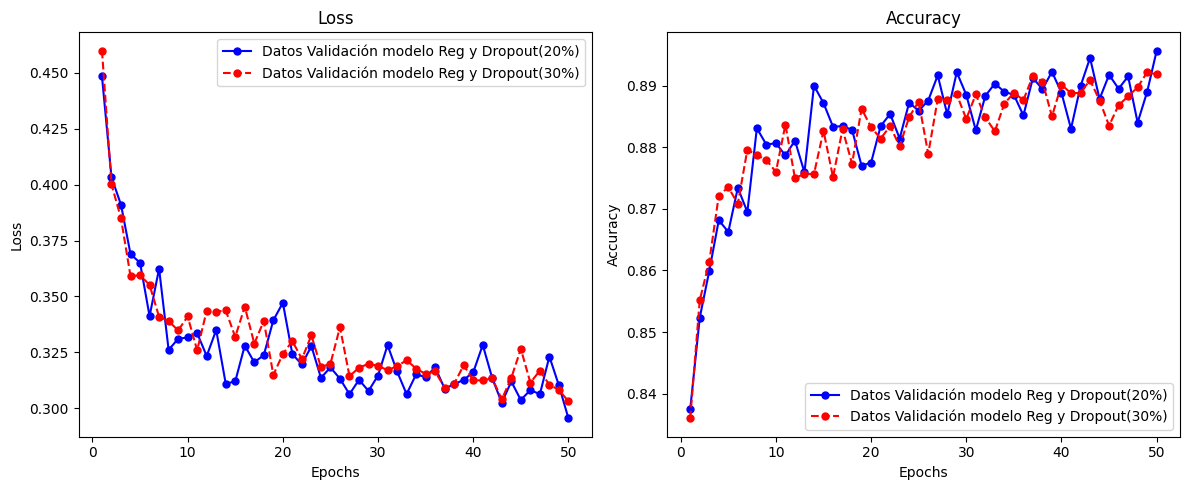

In [19]:
graficar(
    val_losses_5,
    val_losses_4,
    val_accs_5,
    val_accs_4,
    'Datos Validación modelo Reg y Dropout(20%)',
    'Datos Validación modelo Reg y Dropout(30%)',
    'Datos Validación modelo Reg y Dropout(20%)',
    'Datos Validación modelo Reg y Dropout(30%)',
    )

In [24]:
# Make predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_5(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

target_names = [f'clase {num_clase}: ({nombre_prenda})' for num_clase, nombre_prenda in clases.items()]
# Calculate metrics
report = classification_report(all_labels, all_preds, target_names=target_names)

print(report)

                         precision    recall  f1-score   support

clase 0: (Camiseta/Top)       0.80      0.89      0.84      1000
    clase 1: (Pantalón)       0.99      0.97      0.98      1000
      clase 2: (Suéter)       0.83      0.80      0.81      1000
     clase 3: (Vestido)       0.90      0.90      0.90      1000
      clase 4: (Abrigo)       0.79      0.85      0.82      1000
    clase 5: (Sandalia)       0.97      0.95      0.96      1000
      clase 6: (Camisa)       0.76      0.66      0.71      1000
      clase 7: (Zapato)       0.94      0.94      0.94      1000
       clase 8: (Bolsa)       0.97      0.97      0.97      1000
        clase 9: (Bota)       0.94      0.97      0.95      1000

               accuracy                           0.89     10000
              macro avg       0.89      0.89      0.89     10000
           weighted avg       0.89      0.89      0.89     10000



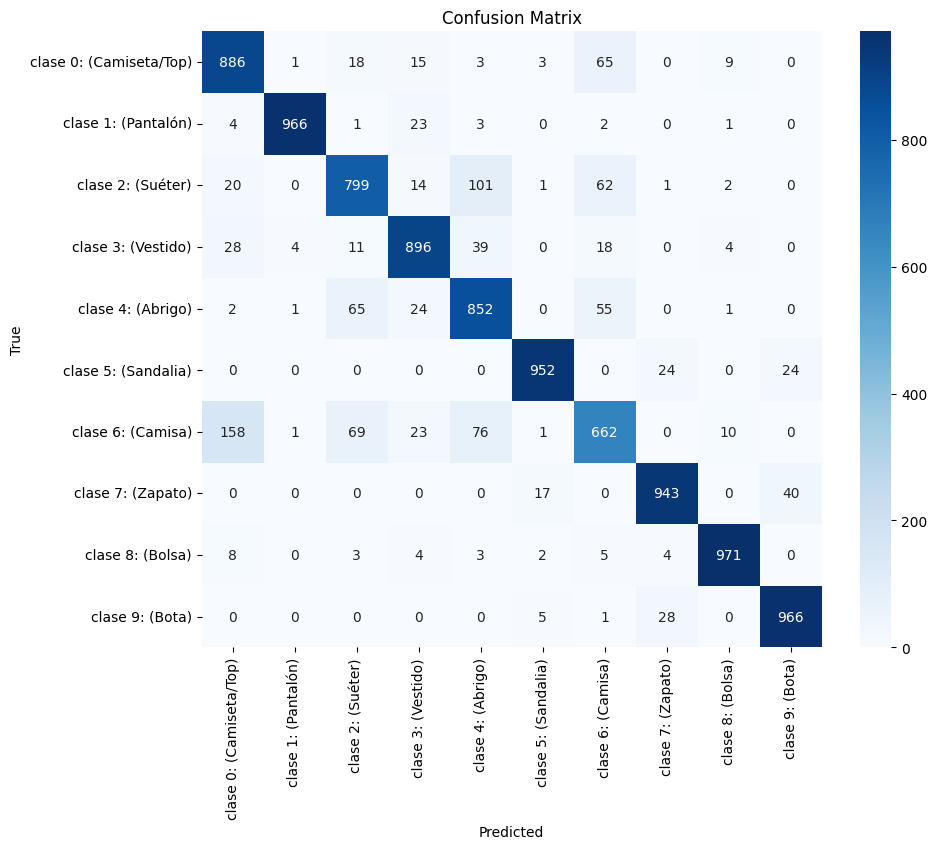

In [32]:
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
torch.save(model_5.state_dict(), 'model_nn_fashion_mnist.pth')